# Data Loading

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the path to the Jelly_Fish_Images directory
data = "Jelly_Fish_Images"

# Set up the ImageDataGenerator for loading the data
datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    validation_split=0.2  # Reserve 20% of data for validation
)

# Load training data
train_generator = datagen.flow_from_directory(
    data,
    target_size=(224, 224),  # ResNet50 expects 224x224 images
    batch_size=32,
    class_mode='categorical',
    subset='training'  # Set as training data
)

# Load validation data
validation_generator = datagen.flow_from_directory(
    data,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'  # Set as validation data`
)


2024-08-12 12:30:23.457091: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-12 12:30:23.461086: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-12 12:30:23.530538: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-12 12:30:23.531839: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-12 12:30:24.436956: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

Found 598 images belonging to 5 classes.
Found 148 images belonging to 5 classes.


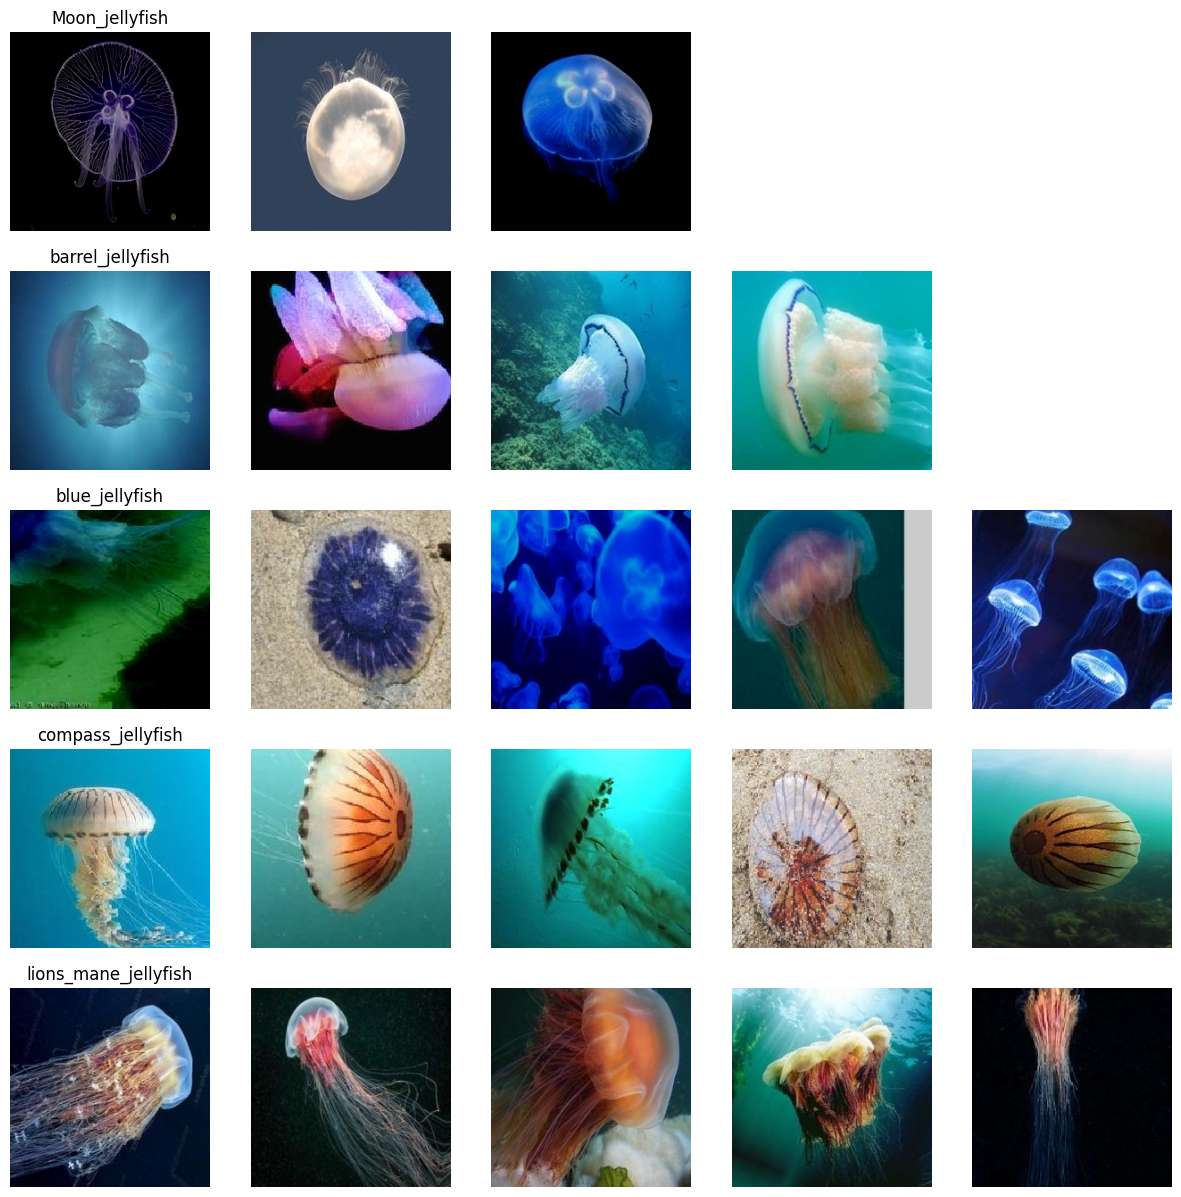

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Get class labels
class_labels = train_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}  # Invert the dictionary

# Plot a few images from each class
def plot_images(generator, class_labels, num_images=5):
    fig, axes = plt.subplots(len(class_labels), num_images, figsize=(15, 15))
    for label, class_name in class_labels.items():
        imgs, labels = next(generator)
        class_imgs = imgs[labels[:, label] == 1]
        
        # If there are fewer images than num_images, fill the remaining with empty plots
        for i in range(num_images):
            ax = axes[label, i]
            if i < len(class_imgs):
                ax.imshow(class_imgs[i])
                ax.axis('off')
            else:
                ax.axis('off')  # Hide axis if no image is available
        axes[label, 0].set_title(class_name)  # Set title only for the first column

    plt.show()

plot_images(train_generator, class_labels)


# Train Base Model

In [4]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Load the ResNet50 model with pre-trained ImageNet weights
base_model = ResNet50(
    include_top=False,  # We will add our own classification head
    weights='imagenet',
    input_shape=(224, 224, 3)
)

# Add a global average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully connected layer with 1024 units and ReLU activation
x = Dense(1024, activation='relu')(x)

# Add the final output layer with softmax activation (adjust classes to your data)
num_classes = train_generator.num_classes
output = Dense(num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=output)

# Freeze the base model layers to prevent them from being trained
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model architecture
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [5]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10  # You can adjust the number of epochs
)

# Save the model
model.save('jellyfish_resnet50_model.h5')


Epoch 1/10
18/18 [==============================] - 23s 1s/step - loss: 2.0724 - accuracy: 0.1873 - val_loss: 1.7521 - val_accuracy: 0.2109
Epoch 2/10
18/18 [==============================] - 19s 1s/step - loss: 1.7143 - accuracy: 0.2173 - val_loss: 1.6654 - val_accuracy: 0.2266
Epoch 3/10
18/18 [==============================] - 18s 1s/step - loss: 1.6192 - accuracy: 0.2739 - val_loss: 1.6170 - val_accuracy: 0.2891
Epoch 4/10
18/18 [==============================] - 18s 1s/step - loss: 1.6234 - accuracy: 0.2261 - val_loss: 1.6031 - val_accuracy: 0.1953
Epoch 5/10
18/18 [==============================] - 19s 1s/step - loss: 1.6181 - accuracy: 0.2615 - val_loss: 1.6484 - val_accuracy: 0.2656
Epoch 6/10
18/18 [==============================] - 19s 1s/step - loss: 1.6287 - accuracy: 0.2756 - val_loss: 1.5597 - val_accuracy: 0.2578
Epoch 7/10
18/18 [==============================] - 19s 1s/step - loss: 1.5301 - accuracy: 0.3604 - val_loss: 1.5992 - val_accuracy: 0.2266
Epoch 8/10
18/18 [==

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [6]:
# Evaluate on the validation data
val_loss, val_acc = model.evaluate(validation_generator)
print(f'Validation accuracy: {val_acc:.2f}')


5/5 [==============================] - 4s 790ms/step - loss: 1.5513 - accuracy: 0.2703
Validation accuracy: 0.27


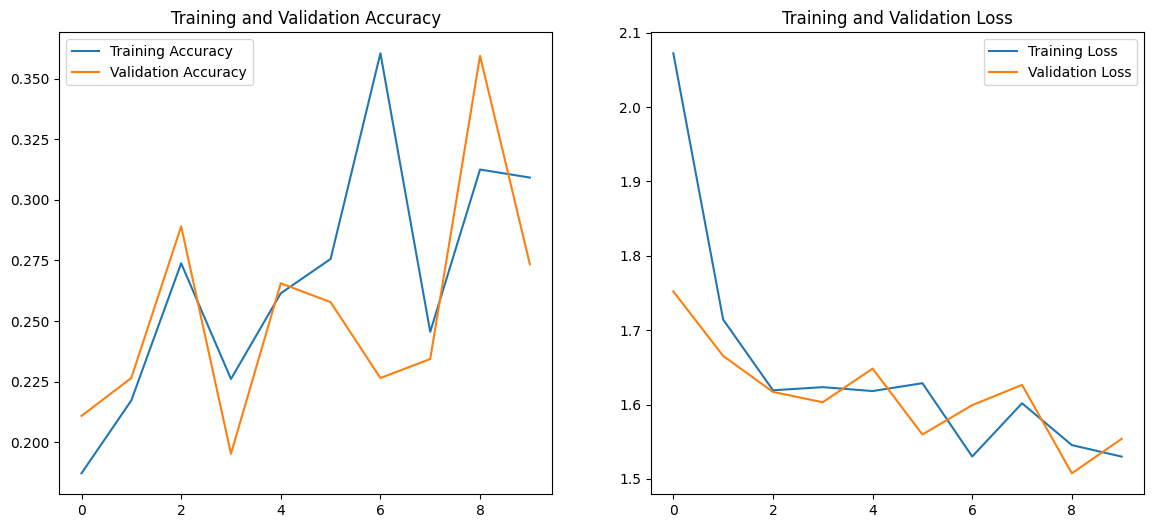

In [7]:
# Plot loss vs accuracy
def plot_loss_accuracy(history):
    epochs = range(len(history.history['loss']))

    plt.figure(figsize=(14, 6))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'], label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()

# Assuming history is from the initial training phase
plot_loss_accuracy(history)


# Train Augmented Base Model

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the augmentation techniques
rotation_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=40,
    validation_split=0.2  # Ensure the same validation split
)

flip_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    horizontal_flip=True,
    validation_split=0.2
)

zoom_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    zoom_range=0.2,
    validation_split=0.2
)

# Create the data generators
train_rotation_generator = rotation_datagen.flow_from_directory(
    data,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

train_flip_generator = flip_datagen.flow_from_directory(
    data,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

train_zoom_generator = zoom_datagen.flow_from_directory(
    data,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

# Validation generator (use one consistent validation set)
validation_generator = rotation_datagen.flow_from_directory(
    data,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 598 images belonging to 5 classes.
Found 598 images belonging to 5 classes.
Found 598 images belonging to 5 classes.
Found 148 images belonging to 5 classes.


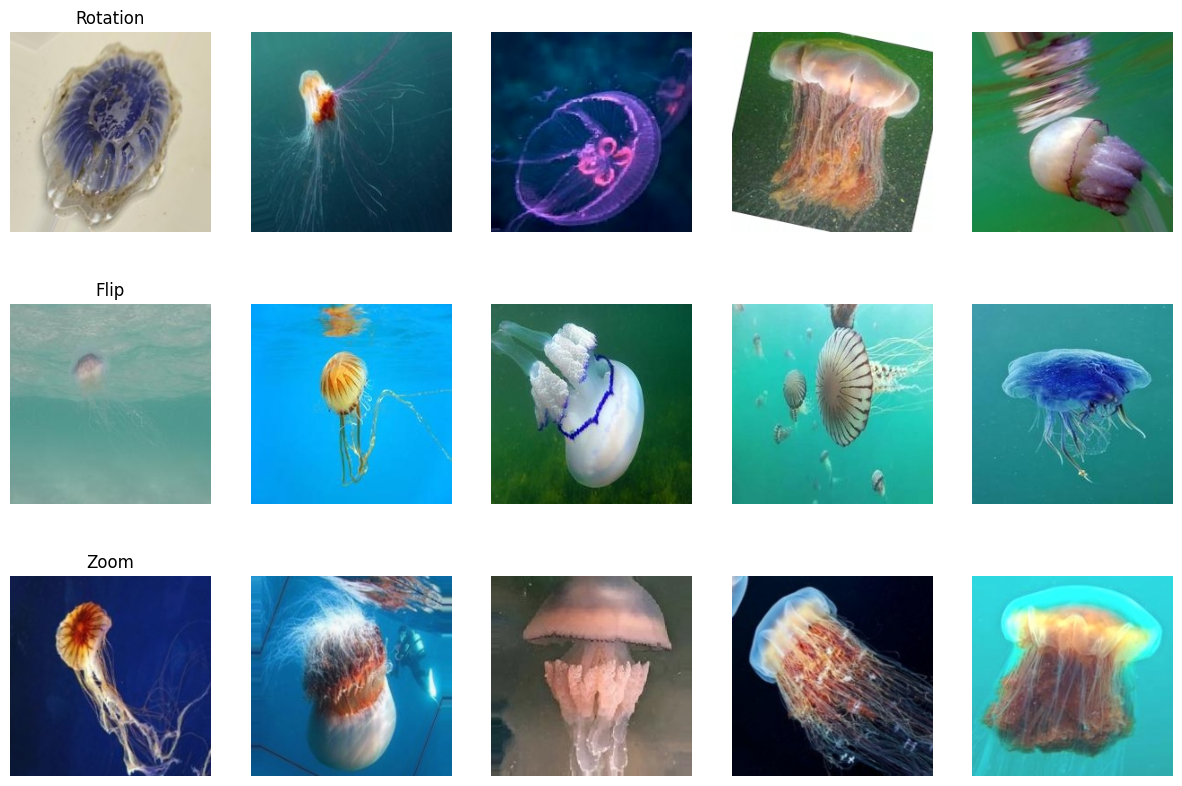

In [10]:
def plot_augmented_images(generator, class_labels, num_images=5):
    fig, axes = plt.subplots(3, num_images, figsize=(15, 10))

    augmentation_methods = ['Rotation', 'Flip', 'Zoom']
    generators = [train_rotation_generator, train_flip_generator, train_zoom_generator]
    
    for idx, gen in enumerate(generators):
        imgs, labels = next(gen)
        for i in range(num_images):
            ax = axes[idx, i]
            ax.imshow(imgs[i])
            ax.axis('off')
        axes[idx, 0].set_title(augmentation_methods[idx])

    plt.show()

plot_augmented_images(train_rotation_generator, class_labels)


Epoch 1/10
18/18 [==============================] - 25s 1s/step - loss: 1.7147 - accuracy: 0.2367 - val_loss: 1.5537 - val_accuracy: 0.2734
Epoch 2/10
18/18 [==============================] - 21s 1s/step - loss: 1.5460 - accuracy: 0.2898 - val_loss: 1.5291 - val_accuracy: 0.3281
Epoch 3/10
18/18 [==============================] - 21s 1s/step - loss: 1.5307 - accuracy: 0.3092 - val_loss: 1.5022 - val_accuracy: 0.3359
Epoch 4/10
18/18 [==============================] - 21s 1s/step - loss: 1.5443 - accuracy: 0.2845 - val_loss: 1.5172 - val_accuracy: 0.3047
Epoch 5/10
18/18 [==============================] - 21s 1s/step - loss: 1.5314 - accuracy: 0.3145 - val_loss: 1.5509 - val_accuracy: 0.2812
Epoch 6/10
18/18 [==============================] - 22s 1s/step - loss: 1.5115 - accuracy: 0.3251 - val_loss: 1.5175 - val_accuracy: 0.2734
Epoch 7/10
18/18 [==============================] - 22s 1s/step - loss: 1.5171 - accuracy: 0.3145 - val_loss: 1.5650 - val_accuracy: 0.3047
Epoch 8/10
18/18 [==

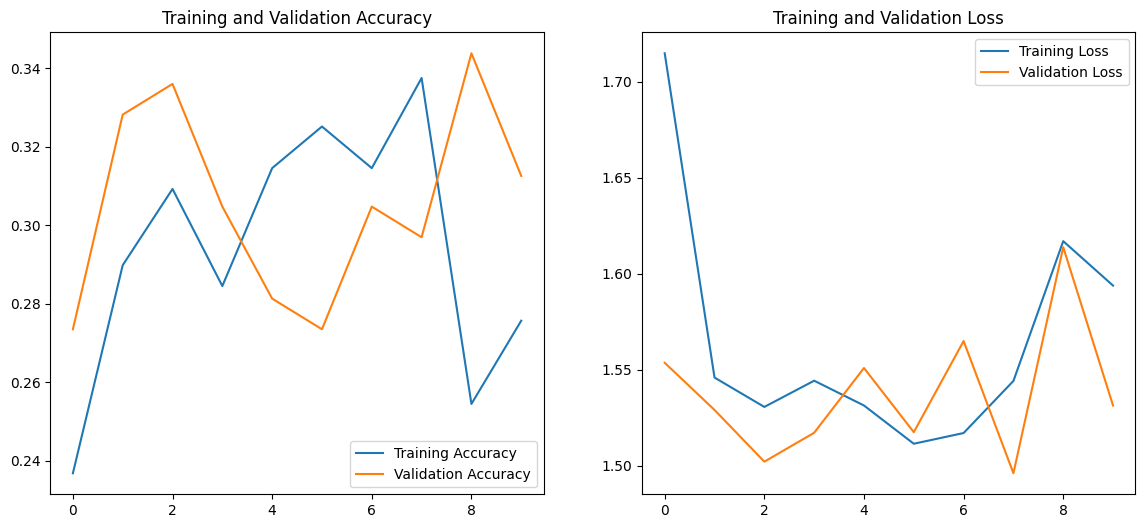

In [11]:
# Compile the model (use the same model architecture as before)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with rotation augmentation
history_rotation = model.fit(
    train_rotation_generator,
    steps_per_epoch=train_rotation_generator.samples // train_rotation_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10  # Adjust the number of epochs as needed
)

# You can also train with flip and zoom augmentations in a similar manner:
# history_flip = model.fit(...)
# history_zoom = model.fit(...)

# Save the model trained with augmented data
model.save('jellyfish_resnet50_rotation_augmented.h5')

# Plot the loss vs accuracy for the augmented model
plot_loss_accuracy(history_rotation)


# Compare Augmented Model

In [12]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Get the ground truth labels
y_true = validation_generator.classes
y_true = label_binarize(y_true, classes=list(range(train_generator.num_classes)))

# Get the predictions from the original model
y_pred_original = model.predict(validation_generator)
# Get the predictions from the augmented model (e.g., rotation augmented)
y_pred_augmented = model.predict(validation_generator)

# For each class, calculate the ROC curve and AUC for both models
fpr_original, tpr_original, roc_auc_original = {}, {}, {}
fpr_augmented, tpr_augmented, roc_auc_augmented = {}, {}, {}

for i in range(train_generator.num_classes):
    fpr_original[i], tpr_original[i], _ = roc_curve(y_true[:, i], y_pred_original[:, i])
    roc_auc_original[i] = auc(fpr_original[i], tpr_original[i])

    fpr_augmented[i], tpr_augmented[i], _ = roc_curve(y_true[:, i], y_pred_augmented[:, i])
    roc_auc_augmented[i] = auc(fpr_augmented[i], tpr_augmented[i])


5/5 [==============================] - 4s 802ms/step


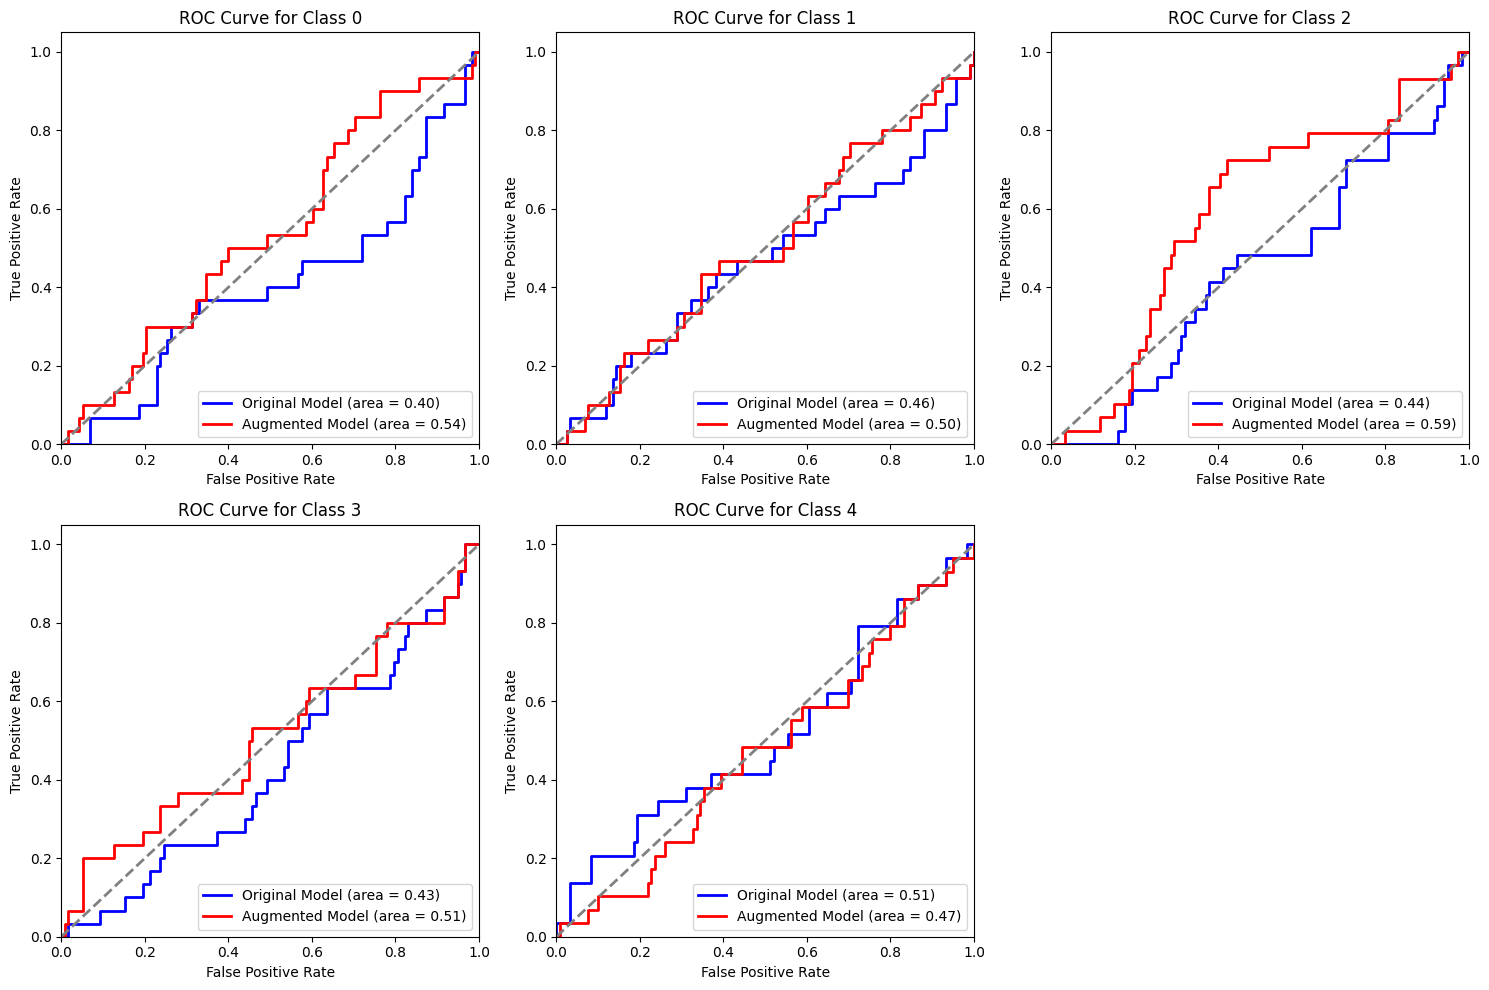

In [13]:
import matplotlib.pyplot as plt

# Plot ROC curves for the first few classes
plt.figure(figsize=(15, 10))
for i in range(min(5, train_generator.num_classes)):  # Adjust the number of classes to plot if needed
    plt.subplot(2, 3, i+1)
    plt.plot(fpr_original[i], tpr_original[i], color='blue', lw=2, label=f'Original Model (area = {roc_auc_original[i]:.2f})')
    plt.plot(fpr_augmented[i], tpr_augmented[i], color='red', lw=2, label=f'Augmented Model (area = {roc_auc_augmented[i]:.2f})')
    plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for Class {i}')
    plt.legend(loc='lower right')

plt.tight_layout()
plt.show()


# Train Model 2


In [ ]:
from tensorflow.keras.applications import NASNetLarge
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Load the NASNetLarge model with pre-trained ImageNet weights
base_model = NASNetLarge(
    include_top=False,  # We will add our own classification head
    weights='imagenet',
    input_shape=(331, 331, 3)
)

# Add a global average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully connected layer with 1024 units and ReLU activation
x = Dense(1024, activation='relu')(x)

# Add the final output layer with softmax activation (adjust classes to your data)
num_classes = train_generator.num_classes
output = Dense(num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=output)

# Freeze the base model layers to prevent them from being trained
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model architecture
model.summary()


343610240/343610240 [==============================] - 8s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 331, 331, 3)]        0         []                            
                                                                                                  
 stem_conv1 (Conv2D)         (None, 165, 165, 96)         2592      ['input_2[0][0]']             
                                                                                                  
 stem_bn1 (BatchNormalizati  (None, 165, 165, 96)         384       ['stem_conv1[0][0]']          
 on)                                                                                              
                                                                                                  
 activation (Activation) 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [15]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10  # Adjust the number of epochs as needed
)

# Save the model
model.save('jellyfish_nasnetlarge_model.h5')


18/18 [==============================] - 79s 4s/step - loss: 1.6726 - accuracy: 0.4717 - val_loss: 0.9294 - val_accuracy: 0.7188
Epoch 2/10
18/18 [==============================] - 60s 3s/step - loss: 0.5991 - accuracy: 0.7792 - val_loss: 0.5749 - val_accuracy: 0.7812
Epoch 3/10
18/18 [==============================] - 62s 4s/step - loss: 0.3819 - accuracy: 0.8569 - val_loss: 0.4189 - val_accuracy: 0.8594
Epoch 4/10
18/18 [==============================] - 60s 3s/step - loss: 0.2993 - accuracy: 0.8922 - val_loss: 0.3641 - val_accuracy: 0.8672
Epoch 5/10
18/18 [==============================] - 58s 3s/step - loss: 0.2124 - accuracy: 0.9293 - val_loss: 0.2929 - val_accuracy: 0.9062
Epoch 6/10
18/18 [==============================] - 60s 3s/step - loss: 0.1751 - accuracy: 0.9576 - val_loss: 0.2272 - val_accuracy: 0.9297
Epoch 7/10
18/18 [==============================] - 59s 3s/step - loss: 0.2046 - accuracy: 0.9223 - val_loss: 0.2324 - val_accuracy: 0.9375
Epoch 8/10
18/18 [=============

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


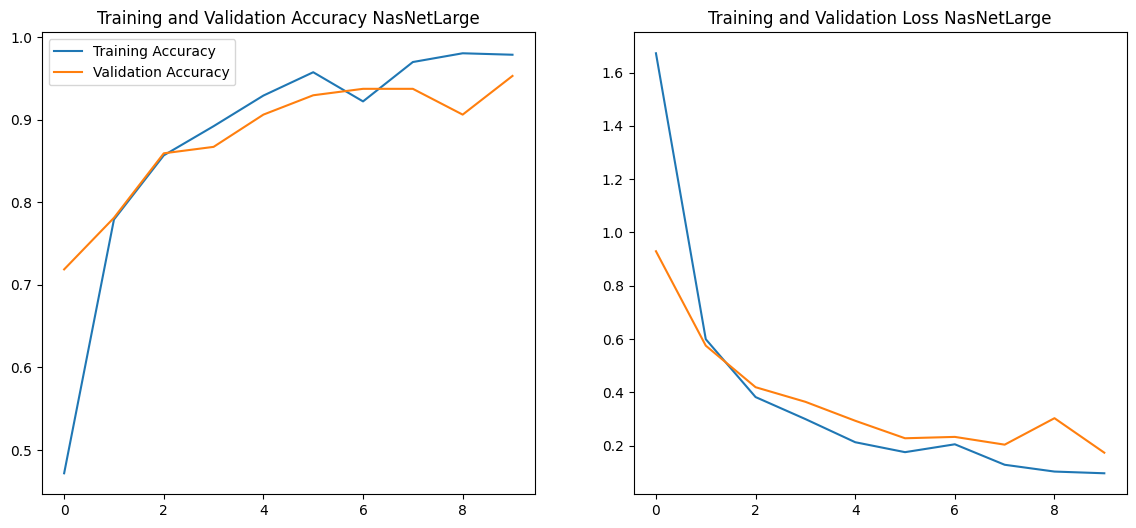

In [18]:
def plot_loss_accuracy(history, title_suffix=""):
    epochs = range(len(history.history['loss']))

    plt.figure(figsize=(14, 6))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Training and Validation Accuracy {title_suffix}')
    plt.legend()

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'], label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
    plt.title(f'Training and Validation Loss {title_suffix}')

    plt.show()

plot_loss_accuracy(history, title_suffix = "NasNetLarge")

# Train Model 3

In [19]:
from tensorflow.keras.applications import EfficientNetV2M
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Load the EfficientNetV2M model with pre-trained ImageNet weights
base_model = EfficientNetV2M(
    include_top=False,  # We will add our own classification head
    weights='imagenet',
    input_shape=(480, 480, 3),
    include_preprocessing=True  # Include preprocessing inside the model
)

# Add a global average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully connected layer with 1024 units and ReLU activation
x = Dense(1024, activation='relu')(x)

# Add the final output layer with softmax activation (adjust classes to your data)
num_classes = train_generator.num_classes
output = Dense(num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=output)

# Freeze the base model layers to prevent them from being trained
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model architecture
model.summary()


214201816/214201816 [==============================] - 7s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 480, 480, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 480, 480, 3)          0         ['input_3[0][0]']             
                                                                                                  
 stem_conv (Conv2D)          (None, 240, 240, 24)         648       ['rescaling[0][0]']           
                                                                                                  
 stem_bn (BatchNormalizatio  (None, 240, 240, 24)         96        ['stem_conv[0][0]']           
 n)                      

In [20]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10  # Adjust the number of epochs as needed
)

# Save the model
model.save('jellyfish_efficientnetv2m_model.h5')


Epoch 1/10
18/18 [==============================] - 52s 2s/step - loss: 1.6494 - accuracy: 0.2226 - val_loss: 1.6195 - val_accuracy: 0.2109
Epoch 2/10
18/18 [==============================] - 34s 2s/step - loss: 1.6429 - accuracy: 0.1873 - val_loss: 1.6113 - val_accuracy: 0.2031
Epoch 3/10
18/18 [==============================] - 35s 2s/step - loss: 1.6280 - accuracy: 0.2032 - val_loss: 1.6108 - val_accuracy: 0.1875
Epoch 4/10
18/18 [==============================] - 36s 2s/step - loss: 1.6259 - accuracy: 0.1979 - val_loss: 1.6036 - val_accuracy: 0.2578
Epoch 5/10
18/18 [==============================] - 37s 2s/step - loss: 1.6207 - accuracy: 0.2191 - val_loss: 1.6070 - val_accuracy: 0.2266
Epoch 6/10
18/18 [==============================] - 35s 2s/step - loss: 1.6248 - accuracy: 0.2049 - val_loss: 1.6113 - val_accuracy: 0.1797
Epoch 7/10
18/18 [==============================] - 35s 2s/step - loss: 1.6199 - accuracy: 0.2014 - val_loss: 1.6082 - val_accuracy: 0.2109
Epoch 8/10
18/18 [==

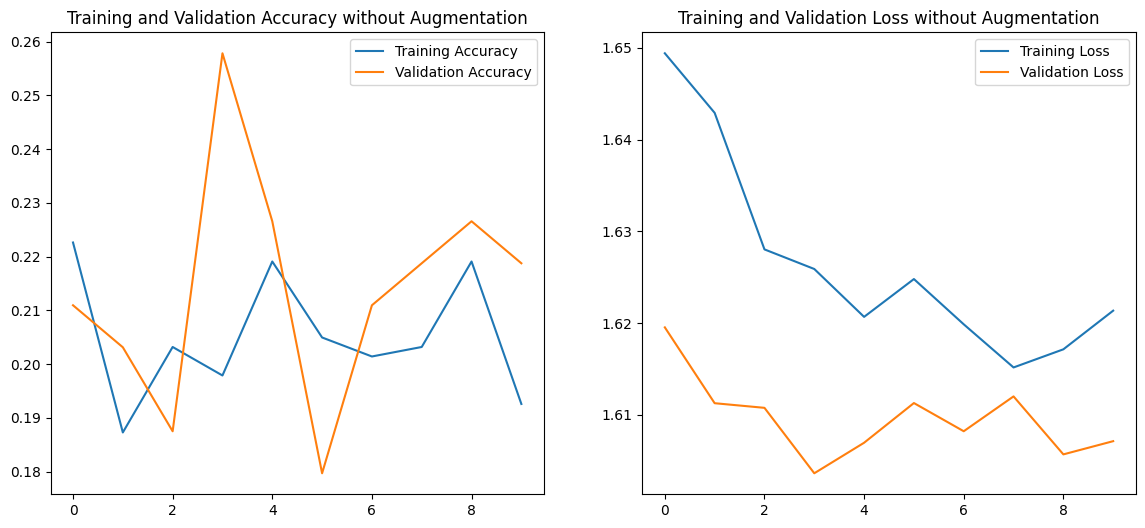

In [21]:
import matplotlib.pyplot as plt

def plot_loss_accuracy(history, title_suffix=""):
    epochs = range(len(history.history['loss']))

    plt.figure(figsize=(14, 6))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Training and Validation Accuracy {title_suffix}')
    plt.legend()

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'], label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
    plt.title(f'Training and Validation Loss {title_suffix}')
    plt.legend()

    plt.show()

# Plot the loss vs accuracy for the model without augmentation
plot_loss_accuracy(history, title_suffix="without Augmentation")


# Compare the 3 Models

In [22]:
from tensorflow.keras.models import load_model

# Load the models
resnet50_model = load_model('jellyfish_resnet50_model.h5')
nasnetlarge_model = load_model('jellyfish_nasnetlarge_model.h5')
efficientnetv2m_model = load_model('jellyfish_efficientnetv2m_model.h5')


In [23]:
# Get the ground truth labels
y_true = validation_generator.classes
y_true = label_binarize(y_true, classes=list(range(train_generator.num_classes)))

# Get predictions from each model
y_pred_resnet50 = resnet50_model.predict(validation_generator)
y_pred_nasnetlarge = nasnetlarge_model.predict(validation_generator)
y_pred_efficientnetv2m = efficientnetv2m_model.predict(validation_generator)


5/5 [==============================] - 11s 1s/step


In [24]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calculate ROC curves and AUC for each model
fpr_resnet50, tpr_resnet50, roc_auc_resnet50 = {}, {}, {}
fpr_nasnetlarge, tpr_nasnetlarge, roc_auc_nasnetlarge = {}, {}, {}
fpr_efficientnetv2m, tpr_efficientnetv2m, roc_auc_efficientnetv2m = {}, {}, {}

for i in range(train_generator.num_classes):
    fpr_resnet50[i], tpr_resnet50[i], _ = roc_curve(y_true[:, i], y_pred_resnet50[:, i])
    roc_auc_resnet50[i] = auc(fpr_resnet50[i], tpr_resnet50[i])

    fpr_nasnetlarge[i], tpr_nasnetlarge[i], _ = roc_curve(y_true[:, i], y_pred_nasnetlarge[:, i])
    roc_auc_nasnetlarge[i] = auc(fpr_nasnetlarge[i], tpr_nasnetlarge[i])

    fpr_efficientnetv2m[i], tpr_efficientnetv2m[i], _ = roc_curve(y_true[:, i], y_pred_efficientnetv2m[:, i])
    roc_auc_efficientnetv2m[i] = auc(fpr_efficientnetv2m[i], tpr_efficientnetv2m[i])


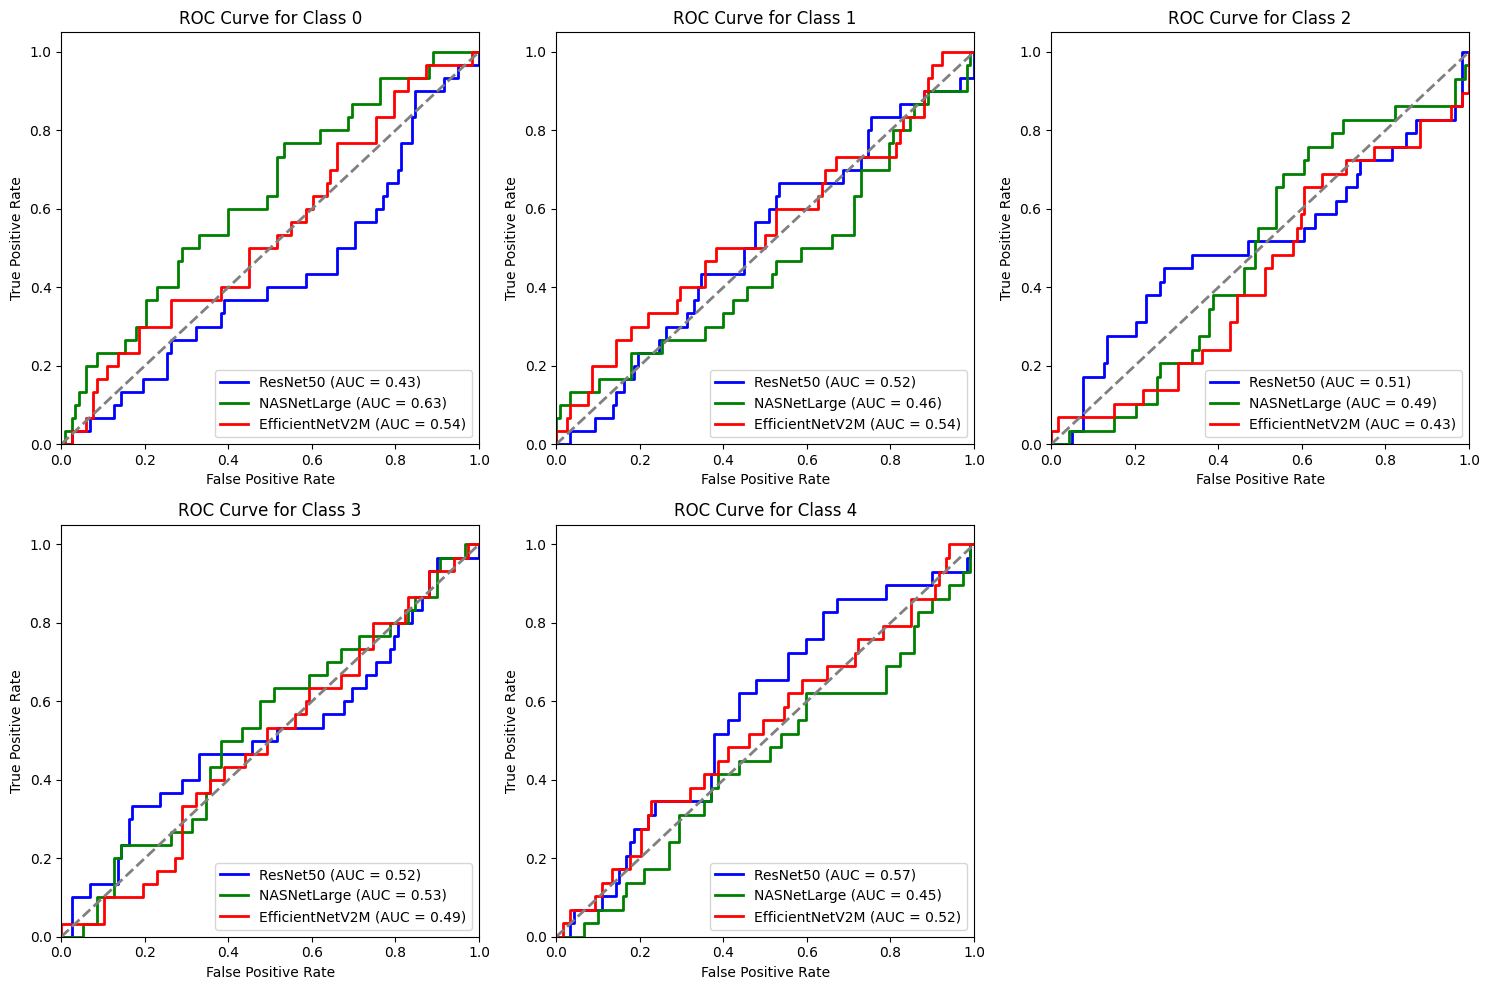

In [25]:
# Plot ROC curves for the first few classes
plt.figure(figsize=(15, 10))
for i in range(min(5, train_generator.num_classes)):  # Adjust the number of classes to plot if needed
    plt.subplot(2, 3, i+1)
    plt.plot(fpr_resnet50[i], tpr_resnet50[i], color='blue', lw=2, label=f'ResNet50 (AUC = {roc_auc_resnet50[i]:.2f})')
    plt.plot(fpr_nasnetlarge[i], tpr_nasnetlarge[i], color='green', lw=2, label=f'NASNetLarge (AUC = {roc_auc_nasnetlarge[i]:.2f})')
    plt.plot(fpr_efficientnetv2m[i], tpr_efficientnetv2m[i], color='red', lw=2, label=f'EfficientNetV2M (AUC = {roc_auc_efficientnetv2m[i]:.2f})')
    plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for Class {i}')
    plt.legend(loc='lower right')

plt.tight_layout()
plt.show()
